In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from keras.metrics import Precision, Recall, AUC, CategoricalAccuracy

from custom_models.augmentation import basic_plus_color_augmentation, basic_augmentation
from custom_models.bilinear_cnns import fe_resnet
from custom_models.cnns import simple_cnn_bn, base_resnet50
from custom_models.optimization_utilities import get_standard_callbacks
from etl.load_dataset import DatasetProcessor, get_tf_eggim_patch_dataset
from optimization.custom_losses import weighted_categorical_crossentropy

2024-12-02 13:37:54.617618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 13:37:54.617680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 13:37:54.617710: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 13:37:54.624857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
target_dir = '../../test_files/EGGIMazing/Dataset01'
model_weights_directory = '../../logs/'
batch_size = 32
num_epochs = 100
learning_rate = 1e-4
num_folds = 5

def get_model_dirs(model_weights_directory, name):
    model_fold_dir = sorted(os.listdir(model_weights_directory))
    model_dirs = [os.path.join(os.path.join(model_weights_directory, x), 'weights.h5')
                  for x in model_fold_dir if x.startswith(name)]
    return model_dirs

In [3]:
baseline_dirs = get_model_dirs(model_weights_directory, 'cv_embc2_patient_resnet_multi')
fe_resnet_dirs = get_model_dirs(model_weights_directory, 'cv_embc2_patient_feresnet')

In [4]:
dp = DatasetProcessor(target_dir)
df = dp.process()
patient_ids = np.load('../../configs/test_patient_ids_2.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [5]:
from sklearn.metrics import confusion_matrix

from evaluation.metrics import categorical_accuracy

from evaluation.metrics import specificity_per_class

from evaluation.metrics import sensitivity_per_class


metrics_baseline = []
metrics_feresnet = []
y_true_ordinals = []
y_baseline_ordinals = []
y_feresnet_ordinals = []

split = dp.patient_wise_split(df_togas,
                                      df_ipo,
                                      patient_ids,
                                      internal_train_size=0.9,
                                      target_variable='eggim_square',
                                      random_state=42)

def compute_metrics(y_true, y_pred, y_true_ordinals, y_pred_ordinals, metrics): # split y_true before and call this for each model
    y_true_ordinal = np.argmax(y_true, axis=-1) # [0 0 1] -> 2
    y_pred_ordinal = np.argmax(y_pred, axis=-1)
    y_true_ordinals.append(y_true_ordinal)
    y_pred_ordinals.append(y_pred_ordinal)
    y_pred_one_hot = np.zeros_like(y_pred)
    y_pred_one_hot[np.arange(len(y_pred)), np.argmax(y_pred, axis=1)] = 1 # [0.2, 0.2, 0.6] -> [0, 0, 1]
    conf_matrix = confusion_matrix(y_true_ordinal, y_pred_ordinal,
                                   labels=[0, 1, 2])
    metrics.append([categorical_accuracy(y_true, y_pred_one_hot),
                    specificity_per_class(conf_matrix), sensitivity_per_class(conf_matrix),
                    conf_matrix])
    return metrics

for fold, (df_train, df_val, df_test) in enumerate(split):
    tf_test_df = get_tf_eggim_patch_dataset(df_test,
                                            num_classes=3,
                                            preprocess_fn=tf.keras.applications.resnet.preprocess_input)

    tf_test_df = tf_test_df.batch(batch_size)

    n_classes = 3  # Replace with the number of classes you have

    #
    baseline = base_resnet50(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    baseline.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    baseline.load_weights(baseline_dirs[fold])

    model = fe_resnet(input_shape=(224, 224, 3), n_classes=n_classes)
    # Compile the model with Adam optimizer 13:21
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=[CategoricalAccuracy(name='cat_accuracy'), Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc')])


    model.load_weights(fe_resnet_dirs[fold])

    y_true = np.concatenate([y for (_, y) in tf_test_df])
    y_pred_baseline = baseline.predict(tf_test_df)
    y_pred_feresnet = model.predict(tf_test_df)
    compute_metrics(y_true, y_pred_baseline, y_true_ordinals, y_baseline_ordinals, metrics_baseline)
    compute_metrics(y_true, y_pred_feresnet, y_true_ordinals, y_feresnet_ordinals, metrics_feresnet)

2024-12-02 13:38:22.539025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 13:38:22.539282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-02 13:38:22.579721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

1/1 [==============================] - 1s 892ms/step


/home/miguelmartins/Projects/eggimazing/evaluation/metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/miguelmartins/Projects/eggimazing/evaluation/metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 933ms/step


/home/miguelmartins/Projects/eggimazing/evaluation/metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 896ms/step


/home/miguelmartins/Projects/eggimazing/evaluation/metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/home/miguelmartins/Projects/eggimazing/evaluation/metrics.py:28: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


1/1 [==============================] - 1s 971ms/step


In [6]:
def parse_metrics(metrics):
    cat_acc = np.array([x[0] for x in metrics])
    spec = np.array([x[1] for x in metrics])
    sens = np.array([x[2] for x in metrics])
    confs = np.array([x[3] for x in metrics], dtype=object)
    return cat_acc, spec, sens

In [7]:
from scipy.stats import ttest_rel
baseline_acc, baseline_spec, baseline_sens = parse_metrics(metrics_baseline)
feresnet_acc, feresnet_spec, feresnet_sens = parse_metrics(metrics_feresnet)

baseline_metrics_list = [baseline_acc, baseline_spec, baseline_sens]
feresnet_metrics_list = [feresnet_acc, feresnet_spec, feresnet_sens]

In [11]:
np.mean(baseline_sens, axis=0), np.mean(feresnet_sens, axis=0)

(array([0.64214557, 0.53311966, 0.43482906]),
 array([0.66999731, 0.51025641, 0.4465812 ]))

In [12]:
baseline_acc

array([0.72727273, 0.54545455, 0.4       , 0.64285714, 1.        ,
       0.84615385, 1.        , 0.83333333, 0.46153846, 0.38461538,
       0.91666667, 0.92857143, 0.5       , 0.66666667, 0.66666667,
       0.75      , 0.53846154, 0.81818182, 0.75      , 1.        ,
       0.63636364, 1.        , 0.81818182, 0.66666667, 0.91666667,
       0.36363636])

In [8]:
def parse_sens_spec(m1, m2):
    m1 = np.nan_to_num(m1, nan=0)
    m2 =  np.nan_to_num(m2, nan=0)

    print(np.mean(m1, axis=0), '+-', np.std(m1, axis=0))
    print(np.mean(m2, axis=0), "+-", np.std(m2, axis=0))
    for i in range(3):
        t_stat, p_value = ttest_rel(np.nan_to_num(m1[:, i], nan=0), np.nan_to_num(m2[:, i], nan=0))
        print(t_stat, p_value)



In [10]:
print("Accuracy")
print("statistically different")
parse_sens_spec(baseline_acc, feresnet_acc)


Accuracy
statistically different
0.7222290529982838 +- 0.19866882490511328
0.7165193780578396 +- 0.23191787520041124


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [11]:
print("Sensitivity")
print("statistically different")
parse_sens_spec(np.delete(baseline_sens, 4, axis=0), np.delete(feresnet_sens, 4, axis=0))

Sensitivity
statistically different
[0.62783139 0.55444444 0.45222222] +- [0.30111432 0.41725736 0.45375797]
[0.6567972  0.53066667 0.46444444] +- [0.28326455 0.4612948  0.44218314]
-0.6859595411642311 0.4993121850802652
0.5155563921264223 0.6108811010516737
-0.48780607717434205 0.6301138690214335


In [12]:
print("Specificity")
parse_sens_spec(np.delete(baseline_spec, 4, axis=0), np.delete(feresnet_spec, 4, axis=0))

Specificity
[0.79528283 0.84753069 0.79896659] +- [0.35733398 0.15379369 0.22747435]
[0.76053535 0.87283128 0.82404973] +- [0.36491853 0.12453479 0.20910315]
1.29068182142798 0.2091098090433341
-0.9013160363723492 0.3763767034224431
-0.5250687331206028 0.6043526550727694


In [17]:
metric_names = ['accuracy', 'specificity', 'sensitivity']
for i, (base, fe) in enumerate(zip(baseline_metrics_list, feresnet_metrics_list)):

    print(f'{metric_names[i]}')
    if i < 1:
        print("Baseline")
        print(f'mean: {np.nanmean(base):.2f}; std: {np.nanstd(base):.2f}; ')
        print("Fe-ResNet50")
        print(f'mean: {np.nanmean(fe):.2f}; std: {np.nanstd(fe):.2f};')
        t_stat, p_value = ttest_rel(base, fe)
        print(f'p-value: {p_value}')
        print()
    else:
        global_base = np.nanmean(base, axis=1)
        global_fe = np.nanmean(fe, axis=1)

        print("Baseline")
        print(f'mean: {np.nanmean(global_base):.2f};  std: {np.nanstd(global_base):.2f}; ')
        #print(f'mean: {np.nanmean(base, axis=0)};  std: {np.nanstd(base, axis=0)}; ')
        print("Fe-ResNet50")
        print(f'mean: {np.nanmean(global_fe):.2f}; std {np.nanstd(global_fe):.2f}')
        #print(f'mean: {np.nanmean(fe, axis=0):.2f};  std: {np.nanstd(fe, axis=0):.2f}; ')
        t_stat, p_value = ttest_rel(np.nan_to_num(global_base, nan=1), np.nan_to_num(global_fe, nan=1))
        print(f'p-value: {p_value}')
        print()


accuracy
Baseline
mean: 0.72; std: 0.20; 
Fe-ResNet50
mean: 0.72; std: 0.23;
p-value: 0.8783222191427136

specificity
Baseline
mean: 0.85;  std: 0.10; 
Fe-ResNet50
mean: 0.84; std 0.12
p-value: 0.651854292814867

sensitivity
Baseline
mean: 0.54;  std: 0.24; 
Fe-ResNet50
mean: 0.54; std 0.25
p-value: 0.7953873774262861



/tmp/ipykernel_3245298/742969411.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(
/tmp/ipykernel_3245298/742969411.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


ValueError: X must have 2 or fewer dimensions

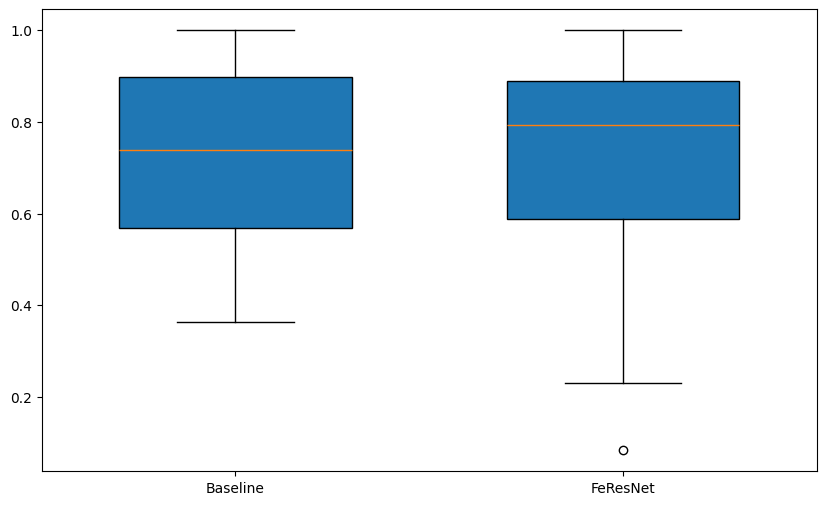

In [31]:
metrics_labels = ['Accuracy', 'Specificity', 'Sensitivity']
baseline_data = baseline_metrics_list
feresnet_data = feresnet_metrics_list

# Combine the data for each metric
data_to_plot = [
    [baseline_data[i], feresnet_data[i]]
    for i in range(len(metrics_labels))
]

# Create boxplots grouped by metric
fig, ax = plt.subplots(figsize=(10, 6))

for i, metric_data in enumerate(data_to_plot):
    positions = [i * 3 + 1, i * 3 + 2]  # Space out the groups
    ax.boxplot(
        metric_data,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        labels=['Baseline', 'FeResNet'] if i == 0 else None,
    )

# Add labels and grid
ax.set_xticks([i * 3 + 1.5 for i in range(len(metrics_labels))])
ax.set_xticklabels(metrics_labels)
ax.set_title('Comparison of Metrics Between Baseline and FeResNet')
ax.set_ylabel('Metric Values')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.legend(["Baseline", "FeResNet"], loc='upper left')
plt.tight_layout()
plt.show()


In [32]:
data = [cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)]

# Create the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['Cat Acc', 'Spec', 'Sens'])
plt.title('Box Plot of Metrics')
plt.ylabel('Values')
plt.grid(True)

# Show the plot
plt.show()

NameError: name 'cat_acc' is not defined

In [33]:
data = np.array([cat_acc, np.nanmean(spec, axis=1), np.nanmean(sens, axis=1)])

NameError: name 'cat_acc' is not defined

In [14]:
data.shape

(3, 26)

In [15]:
np.mean(data, axis=1), np.std(data, axis=1)

(array([0.7674934 , 0.86386544, 0.60097499]),
 array([0.15491663, 0.10772861, 0.21968394]))

In [8]:
from evaluation.eggim import *
def replace_landmark_name(landmark):
    new_landmark_name = {'ii': 'distal body',
                    'ix': 'distal lc',
                    'vi': 'proximal ant lc',
                    'vii': 'proximal ant gc/pw',
                    'viii': 'incisura r',
                    'x': 'upper body r',
                    'xii': 'upper body ant'}
    landmark_number = landmark.split('.')[0]
    return new_landmark_name[landmark_number]

dp = DatasetProcessor(target_dir)
df = dp.process()
df['landmark'] = df['landmark'].apply(replace_landmark_name)
patient_ids = np.load('../../configs/test_patient_ids_2.npy', allow_pickle=True)

togas_ids_boolean = np.array([x.startswith('PT') for x in df['patient_id'].values])
df_togas = df[togas_ids_boolean].reset_index(drop=True)
df_ipo = df[~togas_ids_boolean].reset_index(drop=True)


In [15]:
df_ipo.columns

Index(['bbox', 'eggim_global', 'eggim_square', 'landmark', 'image_directory',
       'patient_id'],
      dtype='object')

In [9]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()
    # we use index[0] to assume first landmark/score pair is correct
    eggim_antrum_incisura = df['proximal ant lc'].index[0] + df['proximal ant gc/pw'].index[0] + df['incisura r'].index[0]
    eggim_body_1 = (df['distal body'].index[0] + df['upper body ant'].index[0]) / 2
    eggim_body_2 = (df['distal lc'].index[0]+ df['upper body r'].index[0]) / 2
    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

eggim_scores = {}
for i, patient_id in enumerate(patient_ids):
    print(patient_id)
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_feresnet_ordinals[i]
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
eggim_df = pd.DataFrame(eggim_scores).T

PT004
PT005
PT006
PT009
PT016
PT020
PT021
PT022
PT024
PT025
PT028
PT029
PT030
PT031
PT034
PT035
PT037
PT039
PT040
PT041
PT045
PT046
PT048
PT049
PT051
PT053


/tmp/ipykernel_3302861/1476169491.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_feresnet_ordinals[i]
/tmp/ipykernel_3302861/1476169491.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_feresnet_ordinals[i]
/tmp/ipykernel_3302861/1476169491.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [10]:
df_patient.to_csv('fe_scores_before_revision.csv')

In [14]:
eggim_df.to_csv("fe_eggim_before_revision.csv")

In [41]:
from sklearn.metrics import confusion_matrix
cutoff = 5
# Function to calculate sensitivity and specificity
def calculate_sensitivity_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return sensitivity, specificity

y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values])
y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

print(np.sum(y != y_pred))

calculate_sensitivity_specificity(np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values]),
                                  np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values]))

7


(0.5, 0.8)

In [11]:
def compute_eggim_patient(patient_df, target_variable):
    df = patient_df[['landmark', target_variable]].value_counts()
    # we use index[0] to assume first landmark/score pair is correct
    eggim_antrum_incisura = df['proximal ant lc'].index[0] + df['proximal ant gc/pw'].index[0] + df['incisura r'].index[0]
    eggim_body_1 = (df['distal body'].index[0] + df['upper body ant'].index[0]) / 2
    eggim_body_2 = (df['distal lc'].index[0]+ df['upper body r'].index[0]) / 2
    return eggim_antrum_incisura + eggim_body_1 + eggim_body_2

eggim_scores = {}
for i, patient_id in enumerate(patient_ids):
    print(patient_id)
    df_patient = df_togas[df_togas['patient_id'] == patient_id]
    df_patient['pred'] = y_baseline_ordinals[i]
    eggim_square = compute_eggim_patient(df_patient,
                                          target_variable='eggim_square')
    eggim_global = compute_eggim_patient(df_patient,
                                  target_variable='eggim_global')
    eggim_pred = compute_eggim_patient(df_patient,
                                  target_variable='pred')
    eggim_scores[patient_ids[i]] = {'eggim_square': eggim_square, 'eggim_global': eggim_global,
                                    'eggim_pred': eggim_pred}
eggim_df = pd.DataFrame(eggim_scores).T

PT004
PT005
PT006
PT009
PT016
PT020
PT021
PT022
PT024
PT025
PT028
PT029
PT030
PT031
PT034
PT035
PT037
PT039
PT040
PT041
PT045
PT046
PT048
PT049
PT051
PT053


/tmp/ipykernel_3302861/1836855989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_baseline_ordinals[i]
/tmp/ipykernel_3302861/1836855989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_patient['pred'] = y_baseline_ordinals[i]
/tmp/ipykernel_3302861/1836855989.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [12]:
df_patient.to_csv('baseline_scores_before_revision.csv')

In [17]:
eggim_df.to_csv("baseline_eggim_before_revision.csv")

In [46]:
from sklearn.metrics import confusion_matrix
cutoff = 5
# Function to calculate sensitivity and specificity
def calculate_sensitivity_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return sensitivity, specificity

y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values])
y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

print(np.sum(y != y_pred))

calculate_sensitivity_specificity(np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values]),
                                  np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values]))

6


(0.5, 0.85)

In [29]:
cutoff = 5
calculate_sensitivity_specificity(np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values]),
                                  np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values]))

(0.5, 0.8)

In [30]:
y = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_square'].values])
y_pred = np.array([1 if eggim >= cutoff else 0 for eggim in eggim_df['eggim_pred'].values])

np.sum(y != y_pred)

7

In [ ]:
print(os.getcwd())

In [ ]:
# minimum error of patch vs global labels
best_possible_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 0]))

In [9]:
# error of patch predictions vs patch labels
patch_eggim_mae =  np.mean(np.abs(eggim_df.iloc[:, 0] -  eggim_df.iloc[:, 2]))

In [13]:
patch_global_eggim_mae = np.mean(np.abs(eggim_df.iloc[:, 1] -  eggim_df.iloc[:, 2]))

In [11]:
patch_eggim_mae

1.4038461538461537

In [ ]:
# patch ground truth vs patch pred:
patch_eggim_mae

In [14]:
# global ground truth vs patch pred
patch_global_eggim_mae

1.4615384615384615

In [ ]:
# global ground truth vs patch pred "adjusted" with minimum error in square labels
patch_global_eggim_mae - best_possible_eggim_mae